# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 10. Распознавание лиц и эмоций

Нужно написать приложение, которое будет получать на вход изображение.
В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from PIL import Image
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from sklearn.utils import shuffle
from torch.utils.data import random_split
import random
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print(f"Using device: {device}")
torch.cuda.empty_cache()

Using device: cpu


## Helper Functions

In [2]:
'''All the helper functions and classes are defined here'''


# dataset class
class HandGestureDataset(Dataset):
    '''This class is used to create a dataset object for the hand gesture dataset.
    The dataset is a collection of images of hand gestures. The dataset is divided into
    folders, each folder containing images of a particular gesture. 
        Args:
            root_dir [str]: Directory with all the folders of images.
            transform (optional) [default= None]: PyTorch transforms for transforms and tensor conversion.
    '''
    # initialize the class
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.subjects = os.listdir(root_dir)
        self.gestures = os.listdir(os.path.join(root_dir, self.subjects[0]))
        self.image_paths = []
        self.labels = []
        for subject in self.subjects:
            for gesture_idx, gesture in enumerate(self.gestures):
                gesture_dir = os.path.join(self.root_dir, subject, gesture)
                for img_name in os.listdir(gesture_dir):
                    img_path = os.path.join(gesture_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(gesture_idx)

    # return the length of the dataset
    def __len__(self):
        return len(self.image_paths)

    # return the image and label at a given index
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label


# function to create a dataset object and return train, validation and test dataloaders
def get_train_val_test_data(root_dir, transform=None, batch_size=64, val_size=0.2, test_size=0.2):
    '''This function is used to create a dataset object and return train, validation and test dataloaders.
        Args:
            root_dir [str]: Directory with all the folders of images.
            batch_size (default= 64) [int]: Batch size for the dataloaders.
            val_size (default= 0.2) [float]: Percentage of the dataset to be used for validation.
            test_size (default= 0.2) [float]: Percentage of the dataset to be used for testing.
            transform (optional) [default= None]: PyTorch transforms for transforms and tensor conversion.

        Returns:
            train_loader [DataLoader]: Dataloader for the training data.
            val_loader [DataLoader]: Dataloader for the validation data.
            test_loader [DataLoader]: Dataloader for the test data.
    '''
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    dataset = HandGestureDataset(root_dir, transform)
    val_len = int(len(dataset) * val_size)
    test_len = int(len(dataset) * test_size)
    train_len = len(dataset) - val_len - test_len

    train_data, val_data, test_data = random_split(
        dataset, [train_len, val_len, test_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

# define a Hyperparameters class to store all the hyperparameters
class Hyperparameters:
    '''This class is used to store all the hyperparameters as global variables.'''
    _GESTURES = ['02_l', '04_fist_moved', '09_c', '10_down', '06_index', '08_palm_moved', '07_ok', '05_thumb', '01_palm', '03_fist']
    num_classes = len(_GESTURES)
    num_epochs = 2
    learning_rate = 1e-3
    weight_decay = 1e-5
    momentum = 0.9
    save_model = True
    save_path = 'model.pt'
    print_every = 50

# define a function to show random 10 images from the dataset with their labels
def show_images(dataloader, class_labels):
    '''This function is used to show random 10 images from the dataset with their labels.
        Args:
            dataloader [DataLoader]: Dataloader for the dataset.
            class_labels [list]: List of labels for the dataset.
    '''
    images = []
    labels = []
    flag = False
    for data in dataloader:
        for i in range(data[0].shape[0]):
            if class_labels[data[1][i].item()] not in labels:
                images.append(data[0][i])
                labels.append(class_labels[data[1][i].item()])
#                 labels.append(data[1][i].item())
                if len(images) >= 10:
                    flag = True
                    break
        if flag:
            break
        
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(labels[i])
        ax.axis('off')
        
    plt.tight_layout()
#     plt.suptitle('Random 10 images from the dataset', fontsize=20)
    plt.show()
    
# define a function to test the model
def test_model(model, data_loader, device):
    '''This function test the given model on the test data.
        Args:
            model [nn.Module]: Model to be tested.
            test_loader [DataLoader]: Dataloader for the test data.
            device [torch.device]: Device on which the model is to be tested.
    '''
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    model.eval()
    
    running_loss = 0.0
    running_correct = 0
    
    with torch.no_grad():
        for image, label in data_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            loss = criterion(output, label)
            running_loss += loss.item() * image.size(0)
            _, preds = torch.max(output, 1)
            running_correct += torch.sum(preds == label.data)
            
    epoch_loss = running_loss / len(data_loader.dataset)
    accuracy = running_correct.double() / len(data_loader.dataset)
    
    return epoch_loss, accuracy.item()
    
    
# define a function to train the model
def train_model(model, train_loader, val_loader, device, params= None):
    '''This function train the given model on the training data and validate it on the validation data and then save the best model (which gives the highest accuracy on the validation data)
        Args:
            model [nn.Module]: Model to be trained.
            train_loader [DataLoader]: Dataloader for the training data.
            val_loader [DataLoader]: Dataloader for the validation data.
            device [torch.device]: Device on which the model is to be trained.
            params (optional) [dictionary (default= None)]: Hyperparameters for training the model.
    '''
    
    if params is None:
        params = {
            'num_epochs': Hyperparameters.num_epochs,
            'learning_rate': Hyperparameters.learning_rate,
            'weight_decay': Hyperparameters.weight_decay,
            'momentum': Hyperparameters.momentum,
            'print_every': Hyperparameters.print_every,
            'save_model': Hyperparameters.save_model,
            'save_path': Hyperparameters.save_path
        }
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['weight_decay'])
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    for epoch in range(params['num_epochs']):
        print(f'*--- Epoch: {epoch+1:>{len(str(params["num_epochs"]))}}/{params["num_epochs"]} -----------------------------------------------------------------------------------------------*')
        running_loss = 0.0
        running_correct = 0
        curr_len = 0
        for batch_idx, (image, label) in enumerate(train_loader):
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            _, preds = torch.max(output, 1)
            
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * image.size(0)
            running_correct += torch.sum(preds == label.data)
            curr_len += image.size(0)
            
            if (batch_idx+1) % params['print_every'] == 0 or batch_idx==0:
                print(f'                ---- Batch: {0 if batch_idx==0 else batch_idx+1:>{len(str(len(train_loader)))}}/{len(train_loader)}    Loss: {running_loss/curr_len:.6f}    Accuracy: {(100*running_correct.double() / curr_len):>7.2f}')
            
            
            
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = running_correct.double() / len(train_loader.dataset)
        
        val_epoch_loss, val_epoch_accuracy = test_model(model, val_loader, device)
        print('|---------------------------------------------------------------------------------------------------------------')
        print(f'  EPOCH: {epoch+1:>{len(str(params["num_epochs"]))}}/{params["num_epochs"]}    Train Loss: {epoch_loss:.6f}    Train Accuracy: {100*epoch_accuracy:.2f}    Val Loss: {val_epoch_loss:.6f}    Val Accuracy: {100*val_epoch_accuracy:.2f}')
        print('---------------------------------------------------------------------------------------------------------------|\n')
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy.item())
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_state = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_state)
    if params['save_model']:
        torch.save(model.state_dict(), params['save_path'])
        
    return model, (train_losses, train_accuracies, val_losses, val_accuracies)

# define a function to plot the training and validation loss and accuracy
def plot_results(results):
    '''This function plots the training and validation loss and accuracy.
        Args:
            results [tuple]: Tuple containing the training and validation loss and accuracy.
    '''
    train_losses, train_accuracies, val_losses, val_accuracies = results
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, '*-', label='Training Loss')
    axes[0].plot(val_losses, '*-', label='Validation Loss')
    axes[0].set_xticks(range(1 + len(train_losses)))
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Loss vs Epochs')
    
    axes[1].plot(train_accuracies, '*-', label='Training Accuracy')
    axes[1].plot(val_accuracies, '*-', label='Validation Accuracy')
    axes[1].set_xticks(range(1 + len(train_losses)))
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_title('Accuracy vs Epochs')
    
    plt.show()


## Dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

root_dir = "leapGestRecog/leapGestRecog/"

train_loader, val_loader, test_loader = get_train_val_test_data(root_dir, transform, batch_size=32, val_size=0.15, test_size=0.15)

print(f"Number of training examples: {len(train_loader.dataset)} ({len(train_loader)} batches)")
print(f"Number of validation examples: {len(val_loader.dataset)} ({len(val_loader)} batches)")
print(f"Number of testing examples: {len(test_loader.dataset)} ({len(test_loader)} batches)")

Number of training examples: 14000 (438 batches)
Number of validation examples: 3000 (94 batches)
Number of testing examples: 3000 (94 batches)


## Random Images

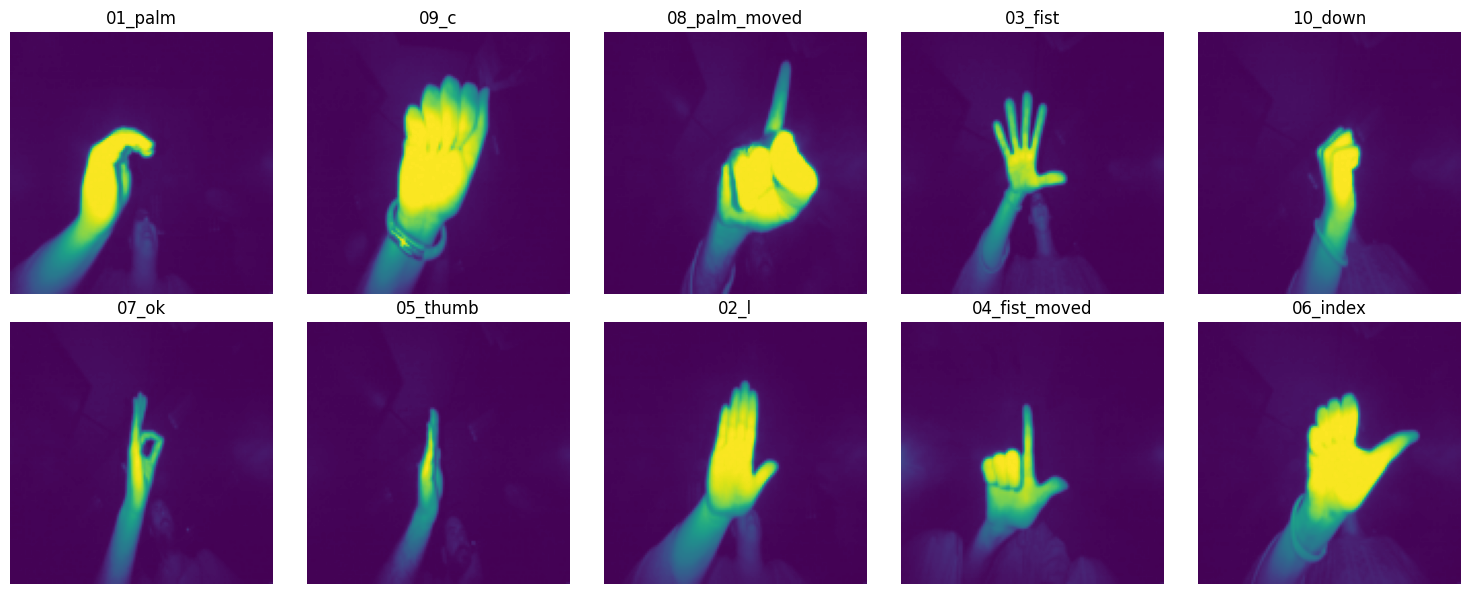

In [4]:
show_images(train_loader, Hyperparameters._GESTURES)

## Model

In [5]:
# define a cnn model to classify the images based on the gestures in the images (10 classes)
class HandGestureModel(nn.Module):
    '''This class is used to create a CNN model to classify the images based on the gestures in the images (10 classes).
        Args:
            num_classes [int]: Number of classes in the dataset.
    '''
    # initialize the class
    def __init__(self, num_classes = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        
        # define the network
        self.network = nn.Sequential(
            # input size: (32, 1, 128, 128) 
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32), # Output size: (32, 32, 128, 128)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: (32, 32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64), # Output size: (32, 64, 64, 64)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: (32, 64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128), # Output size: (32, 128, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2), # Output size: (32, 128, 16, 16)
            
            nn.Flatten(), # Output size: (32, 32768)
            nn.Linear(32768, 1024),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            
            nn.Linear(512, self.num_classes),
            nn.Softmax(dim=1)
        )
        
        
    # define the forward pass
    def forward(self, x):
        '''This function is used to define the forward pass of the model.
            Args:
                x [Tensor]: Input tensor.
            
            Returns:
                x [Tensor]: Output tensor.
        '''
        x = self.network(x)
        return x

## Training Model

In [6]:
model = HandGestureModel()
trained_model , results = train_model(model, train_loader, val_loader, device, params= None)

*--- Epoch: 1/2 -----------------------------------------------------------------------------------------------*
                ---- Batch:   0/438    Loss: 2.303444    Accuracy:    6.25
                ---- Batch:  50/438    Loss: 2.286565    Accuracy:   24.12
                ---- Batch: 100/438    Loss: 2.240129    Accuracy:   31.69
                ---- Batch: 150/438    Loss: 2.155663    Accuracy:   43.71
                ---- Batch: 200/438    Loss: 2.051618    Accuracy:   54.44
                ---- Batch: 250/438    Loss: 1.963029    Accuracy:   61.98
                ---- Batch: 300/438    Loss: 1.894196    Accuracy:   67.56
                ---- Batch: 350/438    Loss: 1.841147    Accuracy:   71.71
                ---- Batch: 400/438    Loss: 1.799248    Accuracy:   74.98
|---------------------------------------------------------------------------------------------------------------
  EPOCH: 1/2    Train Loss: 1.773863    Train Accuracy: 76.89    Val Loss: 1.498750    Val Accuracy

## Testing the Model

In [7]:
test_loss, test_accuracy = test_model(trained_model, test_loader, device)
print(f"Test Loss: {test_loss:.6f}    Test Accuracy: {100*test_accuracy:.2f}%")

Test Loss: 1.475387    Test Accuracy: 98.63%


## Loss Curves

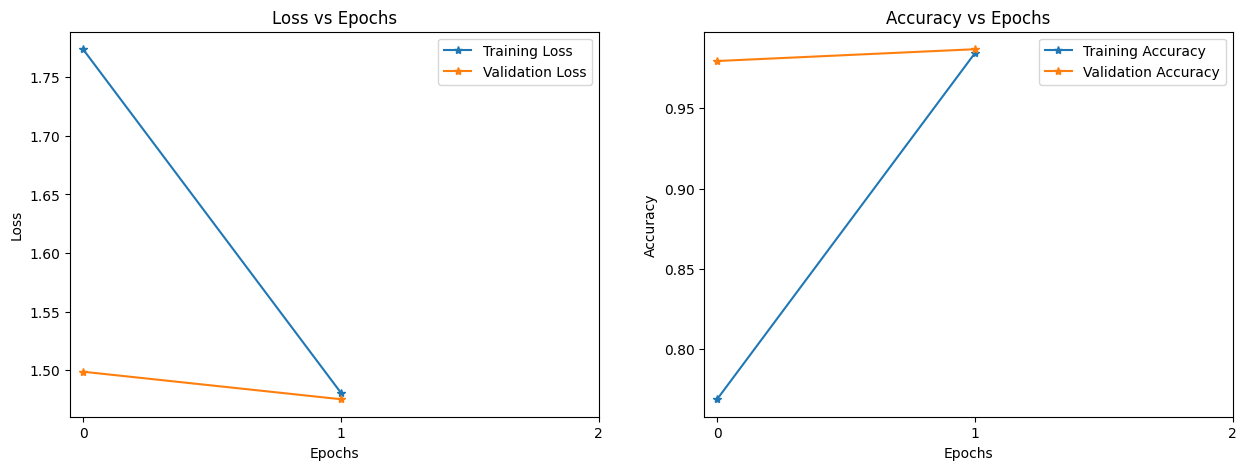

In [8]:
plot_results(results)

In [9]:
#!pip install facenet_pytorch

In [10]:
torch.save(model, 'final_model')

In [11]:
net = torch.load('final_model')
net.eval()

HandGestureModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32768, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, o

## Prediction

In [12]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('final_model')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, landmarks, emotions):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, ld, emotion in zip(boxes, probs, landmarks, emotions):
                # Draw rectangle on frame
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # Show probability
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Draw landmarks
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            #plt.imshow(frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
            #plt.show()
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
       
    def run(self, path_to_img):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(path_to_img)
        
        
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        #print(boxes)

        faces = self.crop_faces(frame, boxes)
        return True if faces else False
       
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)

In [13]:
path_img_test = 'smiling-young-man-with-thumbs-up-gesture-0011361280-preview.jpg'

In [14]:
if fcd.run(path_img_test):
    # Предобработка нового изображения
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    image = Image.open(path_img_test)
    image = transform(image)
    image = image.unsqueeze(0)  # Добавляем размерность пакета

    # Предсказание класса
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)

    class_index = predicted.item()
    class_label = class_index  # Здесь предполагается, что метки классов - числа от 0 до 9

    print(f'Predicted class: {class_label}')

Predicted class: 1
